In [11]:

import SearchingOptimalEnsembles.metadatasets.tabrepo.metadataset as tabrepod
import SearchingOptimalEnsembles.metadatasets.quicktune.metadataset as qtd
import SearchingOptimalEnsembles.metadatasets.ftc.metadataset as ftcd
import SearchingOptimalEnsembles.metadatasets.nasbench201.metadataset as nbd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score, log_loss
from torch import nn

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')

In [12]:
def get_loss_per_sample(metadataset, dataset):
    metadataset.set_state(dataset,
                      split="test")
    X_obs = [i for i in range(len(metadataset.hp_candidates_ids))]
    predictions = metadataset.get_predictions([X_obs])[0]
    predictions = metadataset.get_logits_from_probabilities(predictions)
    y_true = metadataset.get_targets()
    num_base_models, num_samples, num_classes = predictions.shape
    metric = nn.CrossEntropyLoss(reduction="none")
    metric = lambda x,y : (x.argmax(-1)!=y).float()
    temp_targets = torch.tile(y_true.unsqueeze(1), (1,num_base_models))
    temp_pred = predictions.reshape(-1, num_classes)
    loss_per_sample = metric(temp_pred,temp_targets.reshape(-1)).reshape(num_base_models, num_samples)
    return loss_per_sample

14:59 - SEO-METADATASET - DEBUG   - Setting dataset: cifar10
Processing cifar10-0-test: 100%|██████████| 100/100 [00:00<00:00, 319.78it/s]


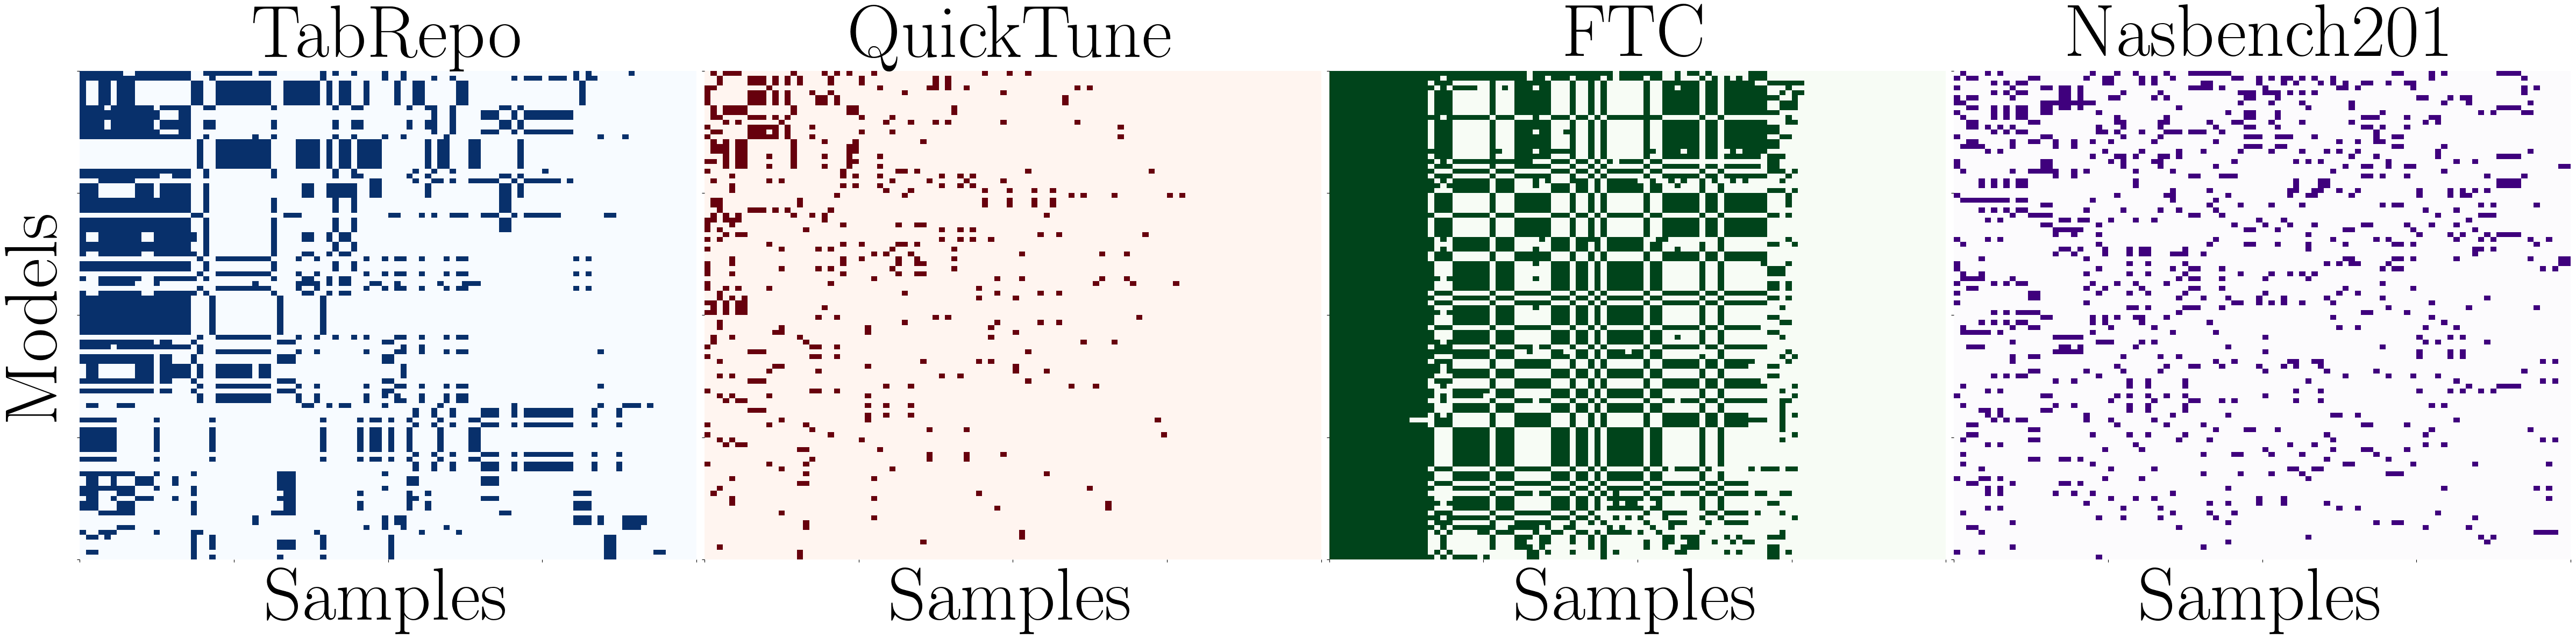

In [15]:
fontsize = 100
np.random.seed(43)

info = [
   ( "TabRepo", tabrepod.TabRepoMetaDataset, 20 ,"Blues"),
   ( "QuickTune", qtd.QuicktuneMetaDataset, 0, "Reds"),
   ( "FTC", ftcd.FTCMetaDataset, 0, "Greens"),
   ( "Nasbench201", nbd.NASBench201MetaDataset, 0, "Purples")
]

fig, axs = plt.subplots(1, 4, figsize=(48, 12))

for i, (title, metadataset_class, dataset_id, cmap_name) in enumerate(info):
    metadataset = metadataset_class()
    dataset = metadataset.get_dataset_names()[dataset_id]
    loss_per_sample = get_loss_per_sample(metadataset, dataset=dataset)
    model_ids = np.random.randint(0, loss_per_sample.shape[0], 100)
    sample_ids = np.random.randint(0, loss_per_sample.shape[1], 100)
    loss_per_sample = loss_per_sample[model_ids][:, sample_ids]
    loss_mean_axis0 = loss_per_sample.mean(0)
    loss_mean_axis1 = loss_per_sample.mean(1)

    loss_per_sample= 1-loss_per_sample[loss_mean_axis1.argsort()].T[loss_mean_axis0.argsort()]
    #cbar = True if i == 3 else False
    cbar=False
    sns.heatmap(loss_per_sample, cmap=cmap_name, cbar=cbar, ax=axs[i])
    if i == 0:
        axs[i].set_ylabel("Models", fontsize=fontsize)
    axs[i].set_xlabel("Samples", fontsize=fontsize)
    axs[i].set_xticks([0, 25, 50, 75, 100])  # Positions of the ticks
    axs[i].set_yticks([0, 25, 50, 75, 100])  # Positions of the ticks
    axs[i].set_title(title, fontsize=fontsize)
    axs[i].tick_params(axis='both', labelsize=fontsize*0.8)

plt.tight_layout()
plt.savefig("saved_plots/motivation_dynamical.pdf", bbox_inches='tight')
